# Pad TRACK Postage Stamp to a Full Frame Image

This notebook will walk through the steps to convert a TRK postage stamp from FGS1 or FGS2 to a full frame image. We need to do this to be able to send track data through MAGIC for verifying if a Photometry Override File is needed. 

In [1]:
import os

from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

<font color='Tomato'> <div style='background-color: rgba(255, 99, 71, 0.3)'><center> 
##    
## Change the parameters in the next cell to match your dataset
##    
</center></div></font>

In [15]:
# Path to your input TRACK file
# Replace with your filename, including it's full path
trk_filename = "/itar/jwst/tel/share/wf_guiding/jw00646012001_gs-track_2020304193319_cal.fits" 

# Grab the root of the input image (or remove what is written and put in your own root)
root = os.path.basename(trk_filename).split('.')[0]

# If you want, replace with where you want the file to be saved and it's new name
out_filename = f"./{root}_full_frame.fits" 

print(f"The full frame image will be saved at {out_filename}")

The full frame image will be saved at ./jw00646012001_gs-track_2020304193319_cal_full_frame.fits


<font color='DodgerBlue'> <div style='background-color: rgba(30, 144, 255, 0.3)'><center> 
##    
## Run the following cells to get your padded TRACK image
##    
</center></div></font>

## Examine the TRK fits file 

In [3]:
fits.info(trk_filename)

Filename: /itar/jwst/tel/share/wf_guiding/jw00646012001_gs-track_2020304193319_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     177   ()      
  1  SCI           1 ImageHDU        36   (32, 32, 3072)   float32   
  2  ERR           1 ImageHDU        10   (32, 32, 3072)   float32   
  3  DQ            1 ImageHDU        11   (32, 32)   int32 (rescales to uint32)   
  4  POINTING      1 BinTableHDU     48   2146R x 12C   [D, D, D, D, D, D, D, D, D, D, D, 16A]   
  5  FGS CENTROID PACKET    1 BinTableHDU     45   2148R x 17C   [23A, 23A, D, D, D, D, D, D, J, J, J, 4A, 12A, 5A, 5A, 5A, 5A]   
  6  TRACK SUBARRAY TABLE    1 BinTableHDU     20   133R x 5C   [23A, D, D, J, J]   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [12590589B]   


We only need 1 track frame with the guide star PSF fully in that frame, so for our purposes, we will just grab the SCI extension and the appropriate header for running this image through MAGIC.

In [4]:
# Read in the TRACK image and get it's header
trk_image = fits.getdata(trk_filename, extname='SCI')
trk_header = fits.getheader(trk_filename, ext=0)

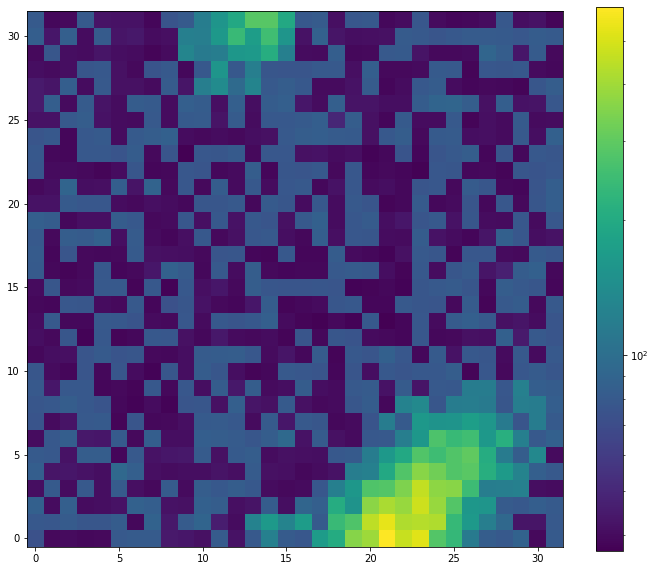

In [5]:
# Plot the first frame in the TRACK cube
plt.figure(figsize=(12, 10))
plt.imshow(trk_image[0], norm=LogNorm(), origin='lower') 
plt.colorbar()
plt.show()

## Find a frame with the full PSF in the TRK window

In [6]:
# How many frames are in this TRK cube?
print(f"Number of frames = {np.shape(trk_image)[0]}")

Number of frames = 3072


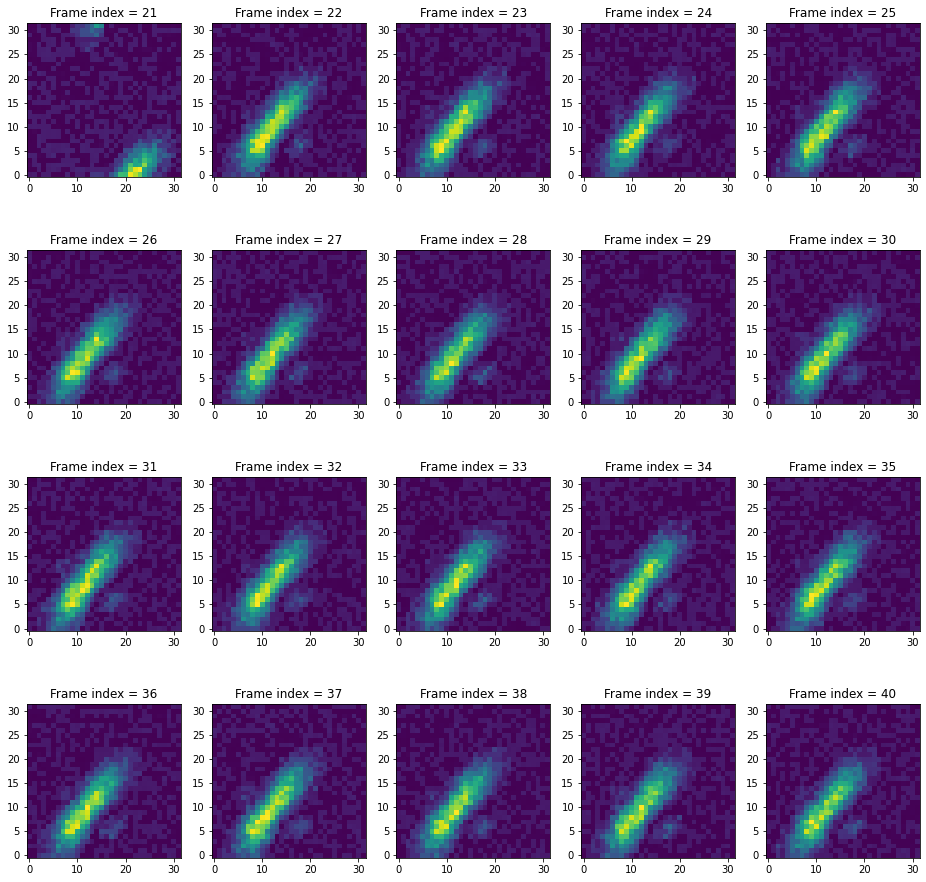

In [7]:
# Change starting_frame_index to look at a different set of frames
starting_frame_index = 21 

# Set the number of rows and columns to display, change these numbers to adjust how many frames you are looking at
nrows = 4
ncols = 5
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 16))

for frame, ax in zip(np.arange(starting_frame_index, starting_frame_index+(nrows*ncols)), axs.reshape(-1)): 
    ax.imshow(trk_image[frame], origin='lower')
    ax.set_title(f"Frame index = {frame}")


Frame 41 (index = 40) looks to have the full PSF in the TRK window so let's use that one

In [8]:
# Choose the frame index of the frame with full PSF in the TRK window
index = 40

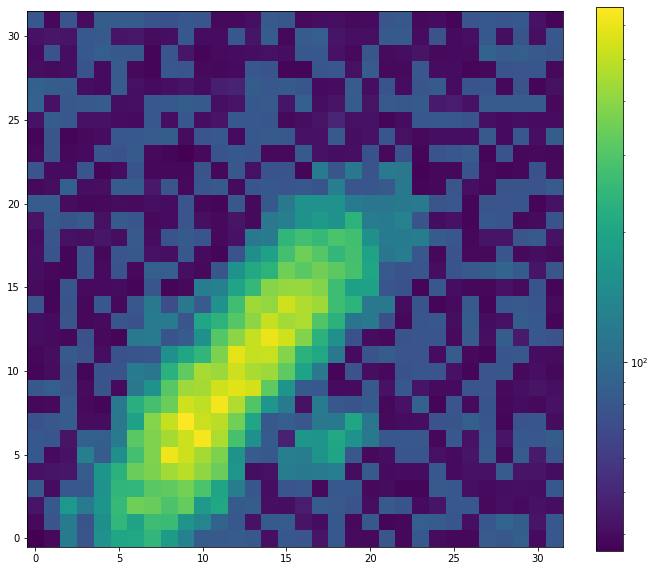

In [9]:
# Plot the first frame in the TRACK cube
plt.figure(figsize=(12, 10))
plt.imshow(trk_image[index], norm=LogNorm(), origin='lower') 
plt.colorbar()
plt.show()

##  Make your full frame image

In [10]:
# Pull science attitude location of postage stamp in the full frame from the header so we know where to put it in 
# the image. Not really necessary, but fun to do.
x_corner = trk_header['SUBSTRT1'] # Starting pixel in axis 1 direction (x for FGS)
y_corner = trk_header['SUBSTRT2'] # Starting pixel in axis 2 direction (y for FGS)

In [11]:
# Check TRK window size
trk_window = trk_image.shape[1] # This should be 32
print("Trk window size: {}".format(trk_window))

Trk window size: 32


In [12]:
# Make your new full frame image and plop the TRK postage stamp where it is in that image
full_window = 2048

trk_full_image = np.zeros((full_window, full_window)) 
trk_full_image[x_corner:x_corner+trk_window, y_corner:y_corner+trk_window] = trk_image[index] 

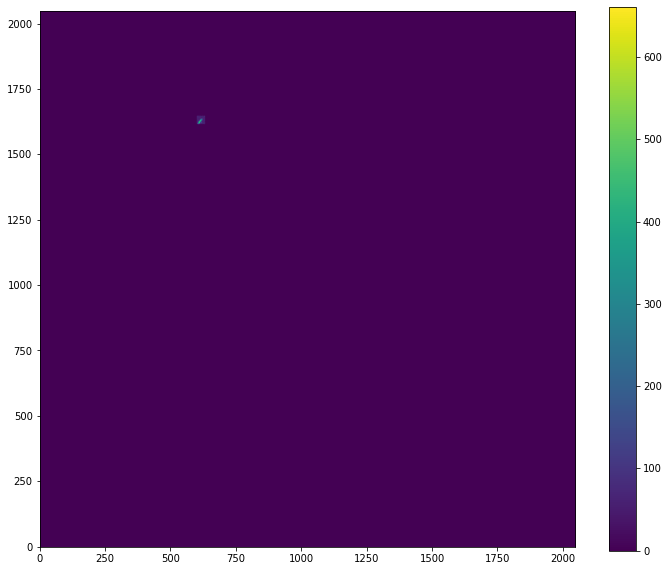

In [13]:
# Plot the padded image to make sure it looks good
plt.figure(figsize=(12, 10))
plt.imshow(trk_full_image, origin='lower') 
plt.colorbar()
plt.show()

In [14]:
hdul = fits.PrimaryHDU(data=trk_full_image, header=trk_header)

hdul.writeto(out_filename, overwrite=True) 